**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC5035 - Proyecto Integrador**

Tecnológico de Monterrey

Prof Horacio Martínez Alfaro

**Módulo 2**
Preparación de los datos

**Equipo 18**

Joaquín Díaz Hernández - A01281536

Divad Alejandro Shriqui Garrón - A01366907

Manuel Romero Alvarez - A00567983


---

# **Ingeniería de Características**

## **Introducción**

El objetivo principal de esta fase es transformar los datos crudos en un conjunto de variables más representativas, informativas y útiles para los algoritmos de aprendizaje automático.

La importancia de esta etapa radica en que la calidad y pertinencia de las características suelen tener un mayor impacto en el desempeño del modelo que la elección del propio algoritmo. Una ingeniería de características bien fundamentada permite:
- Capturar patrones ocultos en los datos.
- Reducir la complejidad y el ruido.
- Mejorar la capacidad predictiva del modelo.
- Disminuir el riesgo de sobreajuste y el tiempo de entrenamiento.

En el contexto de este proyecto, donde buscamos **automatizar y clasificar los gastos de viaje a partir de tickets y registros financieros**, se aplicarán las siguientes estrategias:
- **Generación de nuevas variables** a partir de fechas, montos y descripciones textuales.  
- **Transformaciones matemáticas** (logarítmica, estandarización, normalización) para estabilizar distribuciones y manejar valores extremos.  
- **Codificación de variables categóricas** (one-hot, ordinal) según su cardinalidad.  
- **Métodos de selección de características** (umbral de varianza, correlación, chi-cuadrado, ANOVA).  
- **Técnicas de extracción y reducción de dimensionalidad** (PCA, SVD) para optimizar el espacio de representación.  

Todas las decisiones tomadas serán justificadas con base en la naturaleza de los datos, los objetivos del negocio y la evidencia obtenida durante los experimentos.  
Finalmente, se presentarán las conclusiones de esta fase dentro del marco de **CRISP-ML**, resaltando qué transformaciones y selecciones resultaron más relevantes para el problema de clasificación de gastos.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
DIR = '/content/drive/MyDrive/MNA - Proyecto Integrador/Semana 4/'
os.chdir(DIR)

## **Librerias**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import PowerTransformer
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2, SelectKBest

## **Carga de Datos**

El dataset limpio generado en la entrega anterior contiene la información consolidada de los gastos de viaje.  
A continuación se describen las principales columnas incluidas:

- **CpnyID** → Identificador del mes y año de registro (por ejemplo, “01-24” corresponde a enero de 2024).  
- **Nombre cuenta** → Clasificación contable o tipo de gasto según la empresa (por ejemplo, “Alimentación (GVV)”).  
- **Empleado** → Código interno del empleado que realizó el gasto.  
- **Desc** → Descripción corta o nombre del proveedor (por ejemplo, “MCDONALDS”, “BILLA”).  
- **Batch** → Número de lote o agrupación contable asignado por el sistema.  
- **Referencia** → Identificador del registro del gasto.   
- **Fecha** → Fecha exacta del cargo registrado en la tarjeta o sistema contable.  
- **Desc.1** → Clasificación textual del gasto (por ejemplo, “Alimentación”, “Transporte”, “Hospedaje”).  
- **Cargo** → Monto del gasto registrado en la moneda correspondiente.  
- **Moneda** → Tipo de moneda en que se efectuó el gasto (MXP, USD, etc.).  

Estas variables serán la base para las transformaciones y generación de nuevas características en esta fase de ingeniería de características.

In [6]:
df = pd.read_csv(DIR + "dataset_limpio.csv")
df.head(5)

,CpnyID,Nombre cuenta,Empleado,Desc,Batch,Referencia,Fecha,Desc.1,Cargo,Moneda,CpnyID_dt,Año,Mes,Mes_nombre
0,01-24,Alimentación (GVV),E01013,BILLA,483120.0,814603.0,11/01/2024 00:00:00 a.1./p.1.,Alimentacion,296.70,MXP,2024-01-01,2024,1,January
1,01-24,Alimentación (GVV),E01013,HUDSON,483120.0,814604.0,11/01/2024 00:00:00 a.1./p.1.,Alimentacion,250.91,MXP,2024-01-01,2024,1,January
2,01-24,Alimentación (GVV),E01013,MCDONALDS,483120.0,814605.0,11/01/2024 00:00:00 a.1./p.1.,Alimentacion,281.15,MXP,2024-01-01,2024,1,January
3,01-24,Alimentación (GVV),E01013,A817,483121.0,814606.0,11/01/2024 00:00:00 a.1./p.1.,Alimentacion,266.14,MXP,2024-01-01,2024,1,January
4,01-24,Alimentación (GVV),E01013,ABLA1031,483121.0,814608.0,11/01/2024 00:00:00 a.1./p.1.,Alimentacion,28.22,MXP,2024-01-01,2024,1,January


En la entrega pasada se adelanto un poco a esta fase y se agregaron las siguientes columnas:

- **CpnyID_dt** → Columna derivada que convierte el `CpnyID` en formato de fecha (para análisis temporal).  
- **Año**, **Mes**, **Mes_nombre** → Variables derivadas que facilitan el análisis temporal y la agregación de gastos por periodo.

## **Transformación de variables numéricas**

En esta sección trabajaremos con la variable `Cargo`, ya que es la única variable numérica que resulta relevante para analizar y transformar.  
Las demás variables numéricas presentes en el dataset tienen un propósito más descriptivo o de referencia, principalmente para vincular la información con el ticket correspondiente.

De acuerdo con el análisis exploratorio realizado en la fase anterior, la distribución de `Cargo` presenta un **sesgo positivo (hacia la derecha)**, lo que justifica aplicar una transformación que estabilice la varianza y acerque la distribución a una forma más normal.

Para ello, utilizaremos la transformación **Yeo-Johnson**, la cual es adecuada en este caso porque los valores de la columna `Cargo` son todos positivos y no existen valores iguales a 0 (ya fueron eliminados durante la limpieza de datos en la fase anterior).  

Posteriormente, aplicaremos un proceso de **escalamiento** para normalizar la magnitud de la variable y facilitar su uso en modelos de aprendizaje automático.


In [7]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=15)
    plt.title(f"Histogram of {variable}")
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title(f"Q-Q plot of {variable}")
    plt.show()

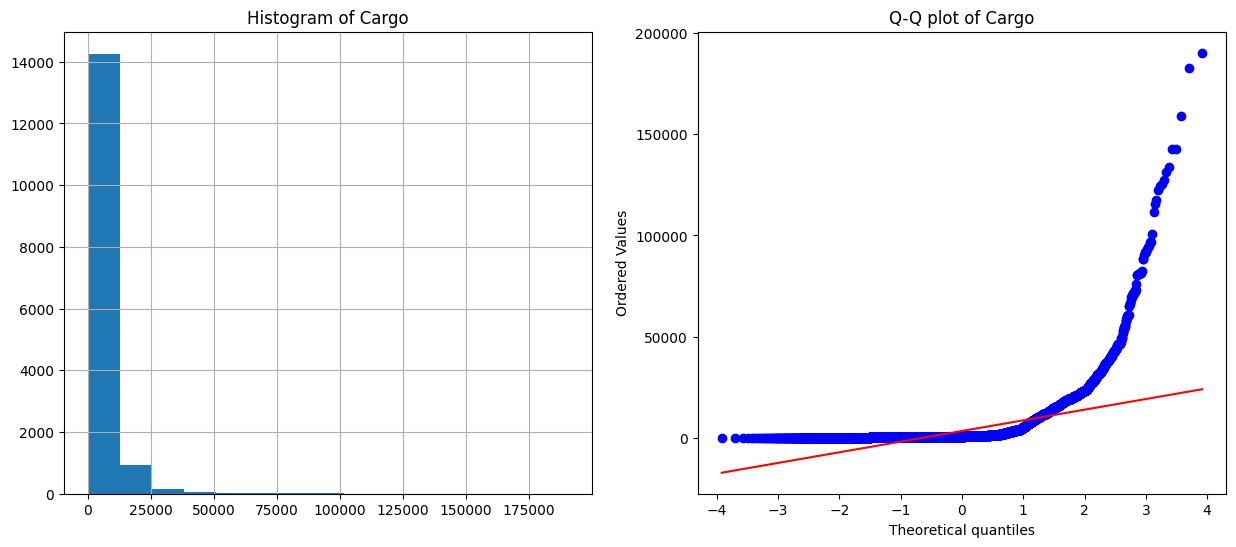

In [8]:
diagnostic_plots(df, 'Cargo')

Los gráficos permiten visualizar el comportamiento sesgado de la variable `Cargo`.  

En el **histograma** se aprecia una fuerte concentración de valores en montos bajos y una cola larga hacia la derecha, mientras que en el **Q–Q plot** los puntos se desvían considerablemente de la línea teórica de normalidad.  

Esto confirma que la variable no sigue una distribución normal y presenta un **sesgo positivo pronunciado**, por lo que resulta apropiado aplicar la transformación **Yeo–Johnson** previamente descrita, con el fin de reducir dicha asimetría y mejorar la estabilidad de los modelos posteriores.

In [9]:
transf_yeo = PowerTransformer(method='yeo-johnson', standardize=False)

In [10]:
transf = transf_yeo.fit_transform(df[['Cargo']])
transf_df = pd.DataFrame(transf, columns=transf_yeo.get_feature_names_out())
transf_df

,Cargo
0,4.556227
1,4.450551
2,4.522439
3,4.487857
4,2.950267
...,...
15478,5.830057
15479,6.530712
15480,5.832834
15481,5.465445


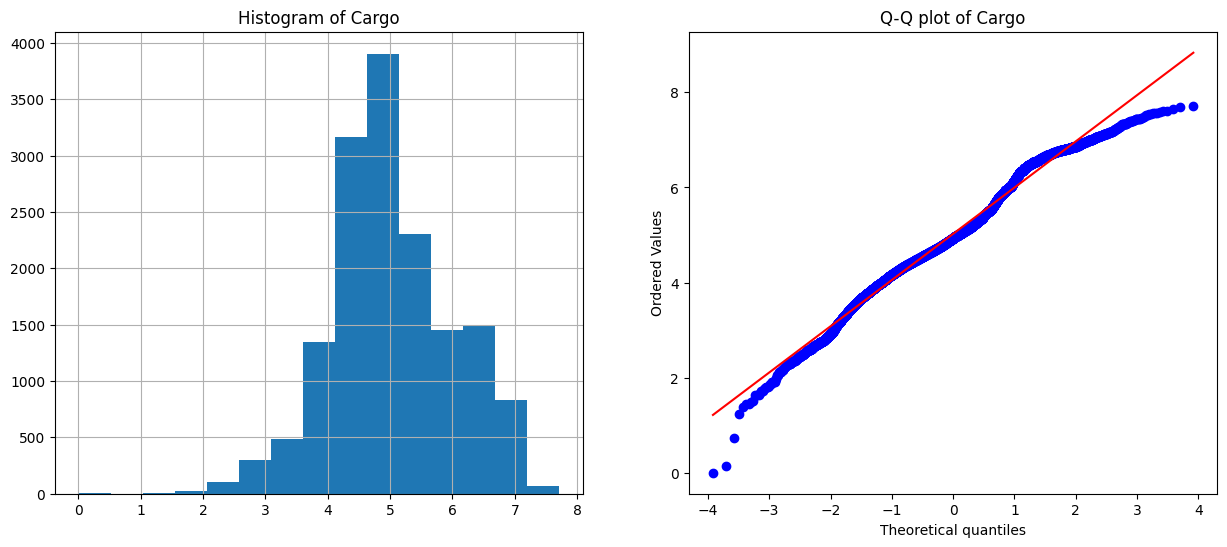

In [11]:
diagnostic_plots(transf_df, 'Cargo')

Después de aplicar la transformación **Yeo–Johnson**, la variable `Cargo` muestra una distribución mucho más simétrica.

El histograma evidencia una reducción notable del sesgo positivo y el Q–Q plot presenta una alineación más cercana a la línea teórica de normalidad, lo que confirma la eficacia de la transformación.

In [12]:
scaler = StandardScaler()
stnd = scaler.fit_transform(transf_df)
stnd_df = pd.DataFrame(stnd, columns=scaler.get_feature_names_out())
stnd_df

,Cargo
0,-0.480301
1,-0.588373
2,-0.514855
3,-0.550221
4,-2.122670
...,...
15478,0.822408
15479,1.538947
15480,0.825248
15481,0.449530


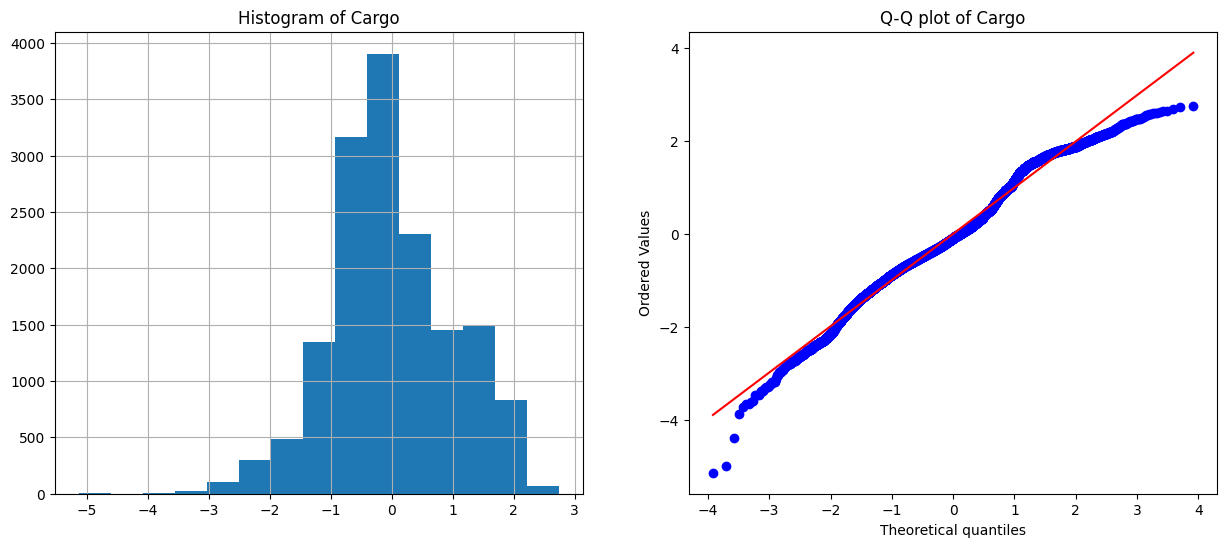

In [13]:
diagnostic_plots(stnd_df, 'Cargo')

Después de aplicar el escalamiento mediante **StandardScaler**, la variable `Cargo` mantiene la forma simétrica obtenida tras la transformación Yeo–Johnson, pero ahora se encuentra centrada en torno a la media cero y con una varianza unitaria.

Esto permite que los valores queden normalizados en magnitud, favoreciendo la comparabilidad con otras variables numéricas y garantizando un comportamiento más estable durante el entrenamiento de los modelos de clasificación.


### Binning de la variable `Cargo`

Se genera una variable categórica Cargo_bin agrupando los montos en cuartiles.

Este enfoque permite representar rangos de gasto de manera más interpretable y detectar posibles patrones de consumo asociados a los distintos niveles de gasto.

In [14]:
df['Cargo_bin'] = pd.qcut(df['Cargo'], q=4, labels=['Bajo', 'Medio', 'Alto', 'Muy alto'])
df['Cargo_bin'].value_counts()

,count
Cargo_bin,
Bajo,3871
Medio,3871
Muy alto,3871
Alto,3870


In [15]:
df.head(5)

,CpnyID,Nombre cuenta,Empleado,Desc,Batch,Referencia,Fecha,Desc.1,Cargo,Moneda,CpnyID_dt,Año,Mes,Mes_nombre,Cargo_bin
0,01-24,Alimentación (GVV),E01013,BILLA,483120.0,814603.0,11/01/2024 00:00:00 a.1./p.1.,Alimentacion,296.70,MXP,2024-01-01,2024,1,January,Medio
1,01-24,Alimentación (GVV),E01013,HUDSON,483120.0,814604.0,11/01/2024 00:00:00 a.1./p.1.,Alimentacion,250.91,MXP,2024-01-01,2024,1,January,Medio
2,01-24,Alimentación (GVV),E01013,MCDONALDS,483120.0,814605.0,11/01/2024 00:00:00 a.1./p.1.,Alimentacion,281.15,MXP,2024-01-01,2024,1,January,Medio
3,01-24,Alimentación (GVV),E01013,A817,483121.0,814606.0,11/01/2024 00:00:00 a.1./p.1.,Alimentacion,266.14,MXP,2024-01-01,2024,1,January,Medio
4,01-24,Alimentación (GVV),E01013,ABLA1031,483121.0,814608.0,11/01/2024 00:00:00 a.1./p.1.,Alimentacion,28.22,MXP,2024-01-01,2024,1,January,Bajo


## **Transformación de variables categóricas**

En esta sección analizamos las variables categóricas del dataset con el objetivo de determinar el tipo de codificación más adecuada según su cardinalidad y su función dentro del modelo.

Primero, recordamos la estructura general de las columnas categóricas mediante el método `describe(include=[object])`, lo que nos permite observar cuántos valores únicos existen en cada una y cuál es el más frecuente.  
Este análisis es importante para distinguir entre variables de **alta cardinalidad** (muchos valores únicos) y **baja cardinalidad** (pocos valores únicos), ya que cada caso requiere un tratamiento diferente.

In [16]:
df.describe(include=['object', 'category']).T

,count,unique,top,freq
CpnyID,15483,21,12-24,1742
Nombre cuenta,15483,3,Alimentación (GVV),10524
Empleado,15483,123,E01013,612
Desc,15483,6442,HOLIDAY INN,503
Fecha,15483,173,17/12/2024 00:00:00 a.12./p.12.,597
Desc.1,15483,3,Alimentacion,10522
Moneda,15483,2,MXP,15469
CpnyID_dt,15483,21,2024-12-01,1742
Mes_nombre,15483,12,December,1742
Cargo_bin,15483,4,Bajo,3871


Las variables de interés para esta etapa son:

- **`Desc`** → contiene el nombre o descripción corta del comercio o proveedor.  
  Presenta **alta cardinalidad** (más de 6,000 valores únicos), lo que hace ineficiente aplicar *One-Hot Encoding*, pues generaría miles de columnas.  
  Por ello, utilizaremos una **codificación binaria**, que permite representar esta variable de forma compacta conservando información relevante.

- **`Moneda`** → presenta **baja cardinalidad** (solo dos valores: MXP y USD).  
  En este caso, aplicaremos **One-Hot Encoding**, ya que generará únicamente dos columnas (una después del drop) y permitirá que el modelo interprete correctamente la moneda sin imponer un orden artificial.

- **`Cargo_bin`** → variable derivada a partir del monto `Cargo`, creada mediante un proceso de *binning* por cuartiles.  
  Presenta **baja cardinalidad** (cuatro categorías: *Bajo*, *Medio*, *Alto* y *Muy alto*), lo que facilita su uso como característica categórica. Se aplicará **One-Hot Encoding**.

- **`Desc.1`** → representa la **variable objetivo (target)** del modelo, es decir, la categoría del gasto (*Alimentación*, *Transporte*, *Hospedaje*).  
  Dado que esta columna será el valor a predecir, **no se codifica** dentro del pipeline de características; se mantiene tal cual para el entrenamiento supervisado.

In [17]:
highly_cardinal_variables = ['Desc']
few_cardinal_variables = ['Moneda', 'Cargo_bin']

In [18]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded = encoder.fit_transform(df[few_cardinal_variables])
onehot_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
onehot_df

,Moneda_USD,Cargo_bin_Bajo,Cargo_bin_Medio,Cargo_bin_Muy alto
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
15478,0.0,0.0,0.0,1.0
15479,0.0,0.0,0.0,1.0
15480,0.0,0.0,0.0,1.0
15481,0.0,0.0,0.0,0.0


In [19]:
encoder = BinaryEncoder()
encoded = encoder.fit_transform(df[highly_cardinal_variables])
binary_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
binary_df

,Desc_0,Desc_1,Desc_2,Desc_3,Desc_4,Desc_5,Desc_6,Desc_7,Desc_8,Desc_9,Desc_10,Desc_11,Desc_12
0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15478,0,0,0,0,0,0,1,1,1,1,0,0,1
15479,0,0,0,0,0,0,1,1,1,1,0,1,0
15480,1,1,0,0,1,0,0,1,0,1,0,1,0
15481,1,1,0,0,1,0,0,1,0,1,0,1,0


En resumen:

| Variable | Tipo de dato | Cardinalidad | Técnica de codificación | Justificación |
|-----------|---------------|---------------|---------------------------|----------------|
| `Desc` | Categórica (texto) | Alta | Codificación binaria | Evita explosión dimensional |
| `Moneda` | Categórica (texto) | Baja | One-Hot Encoding | Facilita interpretación del modelo |
| `Desc.1` | Categórica (texto) | Baja (3 clases) | Ninguna | Es la variable objetivo |

Con esta transformación, garantizamos que las variables categóricas sean interpretadas correctamente por los algoritmos de aprendizaje automático sin generar redundancias ni pérdida de información relevante.

## **Selección y extracción de características**

En esta etapa se define la variable **X**, que representará el conjunto de características (variables de entrada) sobre el cual se aplicarán los métodos de selección y extracción de características.  

Para ello, se elimina la columna **`Desc.1`**, que corresponde a la variable objetivo del modelo de clasificación, así como la columna **`Nombre cuenta`**, ya que ambas contienen información redundante o directamente relacionada con la etiqueta de salida.  

El resultado es un subconjunto del dataset que conserva únicamente las variables predictoras que serán analizadas y transformadas en las siguientes secciones.

> **Nota sobre la relevancia de las variables numéricas**
>
> Aunque en este análisis se aplican técnicas de filtrado y evaluación de características numéricas (como el umbral de varianza o la correlación), es importante señalar que en el contexto de este proyecto la única variable numérica con valor analítico y predictivo significativo es **`Cargo`**, ya que representa el monto del gasto realizado.
>
> Otras variables presentes en el dataset, como **`Empleado`**, **`Referencia`**, **`Batch`** o incluso **`Fecha`** (en su formato original), cumplen un rol más administrativo o de trazabilidad, siendo útiles para vincular los registros con sus tickets o comprobantes, pero **no aportan información relevante para el modelo de clasificación de tipo de gasto (`Desc.1`)**.
>
> Por este motivo, aunque se incluyen los análisis de selección de características por completitud metodológica —y para evidenciar que no existen redundancias numéricas significativas—, las conclusiones de esta sección se centran principalmente en la variable `Cargo`, que es la más representativa desde la perspectiva analítica.

In [20]:
X = df.drop(["Nombre cuenta", "Desc.1", "Empleado", "Batch", "Referencia", "Fecha", "CpnyID"], axis=1)

Se eliminan las columnas `Desc`, `Cargo`, `Moneda` y `Cargo_bin`, para incluir sus transformaciones.

In [21]:
X = X.drop(["Desc", "Cargo", "Moneda", "Cargo_bin"], axis=1)
X_transf = pd.concat([X, onehot_df, binary_df, transf_df], axis=1)

In [22]:
X_transf.head(5)

,CpnyID_dt,Año,Mes,Mes_nombre,Moneda_USD,Cargo_bin_Bajo,Cargo_bin_Medio,Cargo_bin_Muy alto,Desc_0,Desc_1,...,Desc_4,Desc_5,Desc_6,Desc_7,Desc_8,Desc_9,Desc_10,Desc_11,Desc_12,Cargo
0,2024-01-01,2024,1,January,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,0,0,1,4.556227
1,2024-01-01,2024,1,January,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,0,1,0,4.450551
2,2024-01-01,2024,1,January,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,0,1,1,4.522439
3,2024-01-01,2024,1,January,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,1,0,0,4.487857
4,2024-01-01,2024,1,January,0.0,1.0,0.0,0.0,0,0,...,0,0,0,0,0,0,1,0,1,2.950267


In [23]:
Y = df["Desc.1"]

In [24]:
Y.head()

,Desc.1
0,Alimentacion
1,Alimentacion
2,Alimentacion
3,Alimentacion
4,Alimentacion


### Filtro por umbral de varianza

El primer método que aplicaremos es el **umbral de varianza (Variance Threshold)**, una técnica de filtrado que elimina las variables que presentan una varianza muy baja o constante.  

Las variables con varianza cercana a cero aportan poca o ninguna información al modelo, ya que sus valores prácticamente no cambian entre observaciones.

Este paso permite reducir la dimensionalidad del conjunto de características sin pérdida relevante de información.

In [25]:
# Aplicamos el filtro de varianza
selector = VarianceThreshold(threshold=0.0)
selector.fit(X_transf.select_dtypes(include=['number']))

# Contamos cuántas variables fueron eliminadas
num_original = X_transf.select_dtypes(include=['number']).shape[1]
num_retenidas = selector.get_support().sum()

print(f"Variables numéricas originales: {num_original}")
print(f"Variables retenidas tras aplicar VarianceThreshold: {num_retenidas}")

Variables numéricas originales: 20
Variables retenidas tras aplicar VarianceThreshold: 20


El resultado muestra que ninguna variable muestra una varianza de cero.
De esta forma, mantenemos todos las variables.

### Análisis de correlación

Posteriormente, se realiza un **análisis de correlación** entre las variables numéricas.  

Este análisis permite identificar características que contienen información redundante, es decir, aquellas que están altamente correlacionadas entre sí.
  
Cuando dos variables presentan una correlación muy alta (por ejemplo, superior a 0.9), una de ellas puede eliminarse sin afectar de forma significativa el rendimiento del modelo.

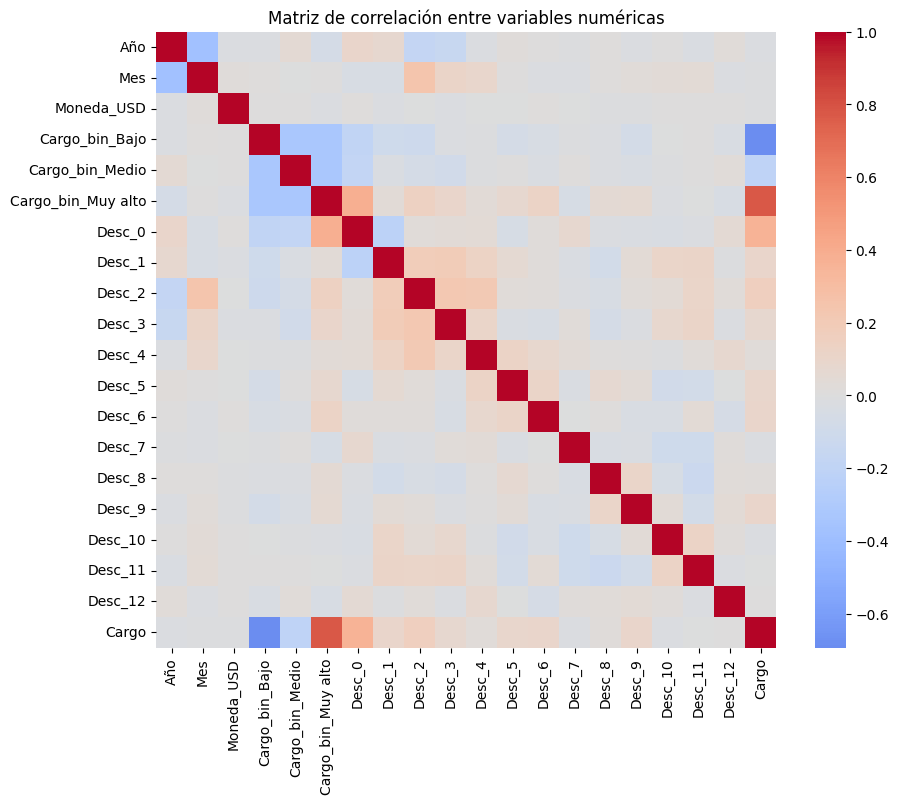

Pares de variables con alta correlación (> 0.9):


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculamos la matriz de correlación para las variables numéricas
corr_matrix = X_transf.select_dtypes(include=['number']).corr()

# Visualizamos la correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

# Identificamos pares altamente correlacionados
threshold = 0.9
corr_pairs = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [(c1, c2, corr_pairs.loc[c1, c2])
             for c1 in corr_pairs.columns
             for c2 in corr_pairs.columns
             if abs(corr_pairs.loc[c1, c2]) > threshold]

print("Pares de variables con alta correlación (> 0.9):")
for pair in high_corr:
    print(pair)

La matriz de correlación muestra que no tenemos pares con realciones lineales fuertes.

La única relación que encuentra es entre la varaible `Cargo` y `Cargo_bin` que creamos, pero ya sabemos de esta relación y consideramos puede ser útil para el modelo.

### Selección supervisada: Chi-cuadrado

El test de **Chi-cuadrado** permite evaluar la dependencia entre variables categóricas y la variable objetivo.

En el contexto de este proyecto, resulta útil para identificar qué variables categóricas codificadas (por ejemplo, `Moneda`, `Cargo_bin`, `Desc`) presentan mayor asociación con la categoría de gasto (`Desc.1`).

In [27]:
X_cat = pd.concat([onehot_df, binary_df], axis=1)

In [28]:
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(X_cat, Y)

# Resultados
chi2_scores = pd.DataFrame({
    'Feature': X_cat.columns,
    'Chi2_Score': chi2_selector.scores_
}).sort_values(by='Chi2_Score', ascending=False)

chi2_scores

,Feature,Chi2_Score
3,Cargo_bin_Muy alto,6636.187918
4,Desc_0,4160.525874
1,Cargo_bin_Bajo,1265.548562
2,Cargo_bin_Medio,1165.126960
6,Desc_2,848.750081
7,Desc_3,719.488484
10,Desc_6,468.626751
9,Desc_5,140.133616
11,Desc_7,122.884961
5,Desc_1,121.098342


En el análisis de Chi-cuadrado, un **valor elevado indica que la variable categórica presenta una fuerte asociación con la variable objetivo (`Desc.1`)**, lo que sugiere que dicha variable puede ser útil como característica predictiva.  

Por el contrario, un **valor bajo refleja poca o nula asociación con la variable objetivo**, por lo que su aporte al modelo de clasificación sería limitado.  

En los resultados obtenidos se observa que las variables derivadas de **`Cargo_bin`** y las variables asociadas a **`Desc`** presentan valores altos de Chi-cuadrado, lo cual era esperado dado que ambas contienen información directamente relacionada con el tipo de gasto.  

En cambio, la variable **`Moneda`** muestra un valor bajo, lo que confirma que el tipo de divisa (MXP o USD) no tiene un impacto significativo en la clasificación de los gastos.

### ANOVA (F-test)

El test **ANOVA (Analysis of Variance)** o **F-test** evalúa la diferencia de medias de una variable numérica entre los distintos grupos definidos por la variable objetivo.

En este caso, se utiliza para analizar si la variable numérica transformada `Cargo` (tras Yeo–Johnson y escalamiento) tiene un poder discriminante entre categorías de gasto (`Desc.1`).

Este resultado es especialmente relevante, ya que complementa lo observado en el análisis de Chi-cuadrado con la variable derivada `Cargo_bin`, reforzando la evidencia de que el monto del gasto es un factor clave en la clasificación.

In [29]:
from sklearn.feature_selection import f_classif

f_scores, p_values = f_classif(X_transf[['Cargo']], Y)

print(f"F-Score de Cargo: {f_scores[0]:.4f}")
print(f"P-Value de Cargo: {p_values[0]:.4f}")

F-Score de Cargo: 6222.7732
P-Value de Cargo: 0.0000


Un valor de F elevado y un p-value bajo indican que la variable `Cargo` presenta diferencias estadísticamente significativas entre las categorías de gasto, lo que la convierte en una característica relevante para el modelo.

>El análisis de extracción de características mediante **PCA** no se consideró en esta fase, ya que el dataset cuenta únicamente con una variable numérica (`Cargo`).
>
>El PCA requiere múltiples variables continuas para identificar combinaciones lineales y reducir la dimensionalidad. En este caso, aplicar el método no aportaría valor adicional, dado que el único componente principal sería equivalente a la propia variable.
>
>En su lugar, se verificó la varianza de las variables numéricas presentes y se confirmó que `Cargo` conserva suficiente información para ser utilizada en el modelado posterior.

## **Conclusiones**

En esta fase se aplicaron diversas técnicas de **ingeniería, selección y extracción de características**, con el objetivo de transformar los datos crudos en un conjunto de variables más representativas y útiles para el modelado de clasificación de gastos.  

Los principales hallazgos y acciones fueron los siguientes:

- **Variable numérica `Cargo`:** se identificó un fuerte sesgo positivo en su distribución, el cual fue corregido mediante la transformación **Yeo–Johnson**, seguida de un **escalamiento estándar (StandardScaler)**. Esto permitió obtener una representación más simétrica y comparable con otras variables.  

- **Generación de nuevas características:** se creó la variable **`Cargo_bin`** mediante *binning* por cuartiles, con lo que se definieron cuatro rangos de gasto (*Bajo, Medio, Alto, Muy alto*). Esta transformación aporta interpretabilidad y mostró asociación significativa con la variable objetivo.  

- **Variables categóricas:**  
  - `Moneda` y `Cargo_bin` → tratadas con **One-Hot Encoding** al tener baja cardinalidad.  
  - `Desc` → procesada con **codificación binaria** debido a su alta cardinalidad.  
  - `Desc.1` → se mantuvo sin transformar al ser la **variable objetivo**.

- **Variables excluidas:** se decidió no utilizar columnas como **`Batch`**, **`Referencia`** y **`Fecha`** (en su formato original) dentro del modelo, ya que no aportan información predictiva para la clasificación. Sin embargo, se conservan en el dataset para fines de trazabilidad y vinculación con los tickets, donde sí resultan útiles.  

- **Selección de características:**  
  - El filtro por **umbral de varianza** y el análisis de **correlación** confirmaron que no existen redundancias significativas entre las variables numéricas.  
  - El test de **Chi-cuadrado** evidenció que las variables derivadas de `Cargo_bin` y `Desc` aportan mayor poder predictivo, mientras que `Moneda` tiene un valor limitado.  
  - El **ANOVA (F-test)** confirmó que `Cargo` presenta diferencias significativas entre categorías de gasto, reforzando su importancia como predictor clave.  

- **Extracción de características (PCA):** se evaluó la posibilidad de aplicar **PCA**, pero se descartó en esta fase debido a que el dataset contiene pocas variables numéricas relevantes y no presenta alta dimensionalidad.

En conclusión, tras esta fase se obtuvo un conjunto de características **depuradas, transformadas y codificadas**, reduciendo sesgos, redundancias y escalas heterogéneas. Esto garantiza que los datos están en condiciones óptimas para la siguiente fase.